In [34]:
####import libraries

import pandas as pd
import numpy as np
from operator import itemgetter

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm_notebook

import scipy.stats
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,make_scorer,fbeta_score
from sklearn.metrics import average_precision_score,plot_precision_recall_curve,precision_recall_curve
from sklearn.metrics import roc_auc_score,roc_curve, auc, brier_score_loss

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,StackingClassifier
import catboost as cb
import clean_text as ct

#### Dataset import and some quick exploration

In [2]:
tweets = pd.read_csv('climate_change_tweets_sample-2020-05-16-17-57.csv')
tweets.head()

,username,user_handle,date,retweets,favorites,text,label
0,WWF Climate & Energy,climateWWF,2020-04-28,11,22,Economic recovery and national climate pledges...,0
1,WWF Climate & Energy,climateWWF,2020-04-22,6,16,"In this difficult time, it’s hard to connect w...",0
2,WWF Climate & Energy,climateWWF,2020-04-01,43,69,"The decision to postpone # COP26, is unavoidab...",0
3,WWF Climate & Energy,climateWWF,2020-03-30,24,30,Japan - the world’s fifth largest emitter of g...,0
4,WWF Climate & Energy,climateWWF,2020-03-30,22,40,How can countries include # NatureBasedSolutio...,0


In [3]:
clean_text = ct.CleanText()
tweets["text"] = clean_text.fit_transform(tweets.text)
tweets = tweets.loc[(~tweets.text.isnull()), :]

In [4]:
#tweets.to_csv("clean_tweets.csv",index=False) # save once processed
# tweets = pd.read_csv("clean_tweets.csv")
# tweets.head()

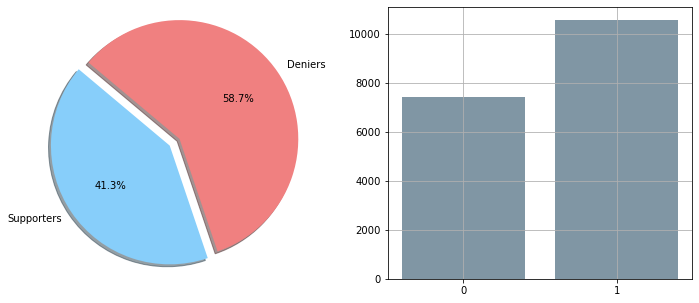

In [5]:
# Data to plot
fig, ax = plt.subplots(figsize=(12,5),nrows=1,ncols=2)

labels = 'Supporters', 'Deniers'
sizes = len(tweets.label.values[tweets.label.values==0]),len(tweets.label.values[tweets.label.values==1])
colors = ['lightskyblue','lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
ax[0].pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

ax[0].axis('equal')


labels, counts = np.unique(tweets.label.values, return_counts=True)
ax[1].bar(labels, counts, align='center',color='#607c8e',alpha=0.8)
ax[1].set_xticks(labels)
ax[1].grid()


plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(tweets.text, tweets.label, 
                                                    test_size=0.2, random_state=17, 
                                                    shuffle=True) # explicit default

###### Bag-Of-Words and Scaling

![BagOfWords](https://www.novuslight.com/uploads/n/BagofWords.jpg)

In [7]:
#Bigrams representation (1,2)
BOW_vectorizer = CountVectorizer(stop_words = 'english', 
                                 binary=True, 
                                 ngram_range=(1,2),            
                                 min_df = 10)

BOW_vectorizer.fit(X_train)
BOW_train = BOW_vectorizer.transform(X_train)
BOW_test = BOW_vectorizer.transform(X_test)


#### BE CAREFUL!!!! ####
scaler_BOW = MaxAbsScaler()  ####<-- For BOW scaling is reduntant, but I do it in matters of consistency.

X_train = scaler_BOW.fit_transform(BOW_train)
X_test = scaler_BOW.transform(BOW_test)

In [8]:
kfcv = KFold(n_splits=5,shuffle=True,random_state=101)

## Random Forest

In [10]:
rf_accuracy = []
best = 0
for train_index, val_index in tqdm_notebook(kfcv.split(X_train,y_train)):
    XX_train, XX_val = X_train[train_index], X_train[val_index]
    yy_train, yy_val = y_train.values[train_index], y_train.values[val_index]
    clf = RandomForestClassifier(**{'bootstrap': True,'max_depth': None,'max_features': 'log2',
                                    'min_samples_leaf': 1,'min_samples_split': 10,'n_estimators': 300,
                                    'random_state':17})
    clf.fit(XX_train,yy_train)
    pred = clf.predict(XX_val)
    accuracy = accuracy_score(yy_val,pred)
    rf_accuracy.append(accuracy)
    if accuracy > best:
        best = accuracy
        best_model = clf

c:\users\jason\anaconda3\envs\sl\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


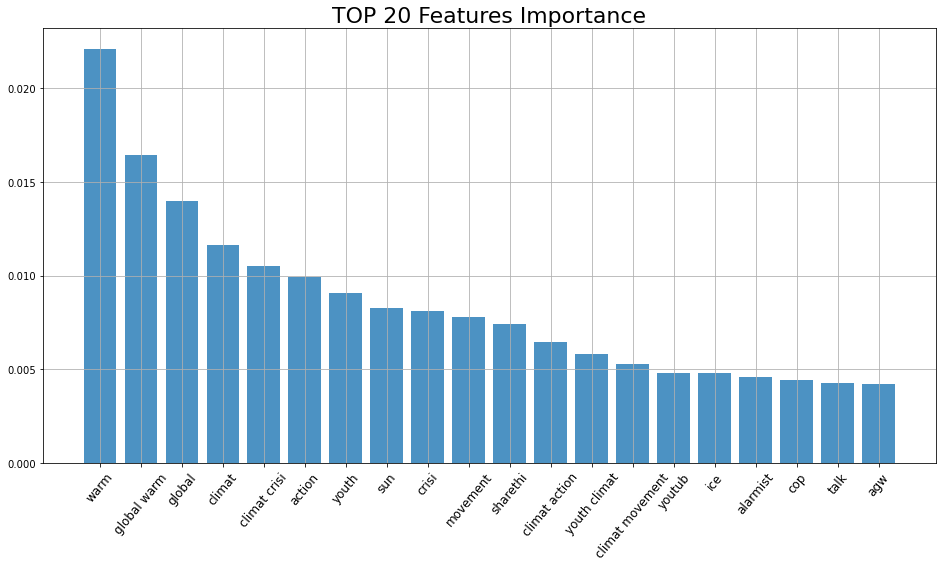

In [11]:
importance = best_model.feature_importances_

indices, importance_sorted = zip(*sorted(enumerate(importance), key=itemgetter(1),reverse=True))

indices,importance_sorted = indices[:20],importance_sorted[:20]

feature_names = BOW_vectorizer.get_feature_names()
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance_sorted))], importance_sorted,align='center',alpha=0.8)
plt.xticks(ticks=range(len(top_features)),labels=top_features,rotation=50,fontsize=12)
plt.title('TOP 20 Features Importance',fontsize=22)
plt.grid()
plt.show()

## Logistic Regression

In [12]:
log_reg_accuracy = []
best = 0
for train_index, val_index in tqdm_notebook(kfcv.split(X_train,y_train)):
    XX_train, XX_val = X_train[train_index], X_train[val_index]
    yy_train, yy_val = y_train.values[train_index], y_train.values[val_index]
    clf = LogisticRegression(**{'C':1,'max_iter':1000, 'multi_class':"ovr", 'solver':"saga",'random_state':17})
    clf.fit(XX_train,yy_train)
    pred = clf.predict(XX_val)
    accuracy = accuracy_score(yy_val,pred)
    log_reg_accuracy.append(accuracy)
    if accuracy > best:
        best = accuracy
        best_model = clf

c:\users\jason\anaconda3\envs\sl\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


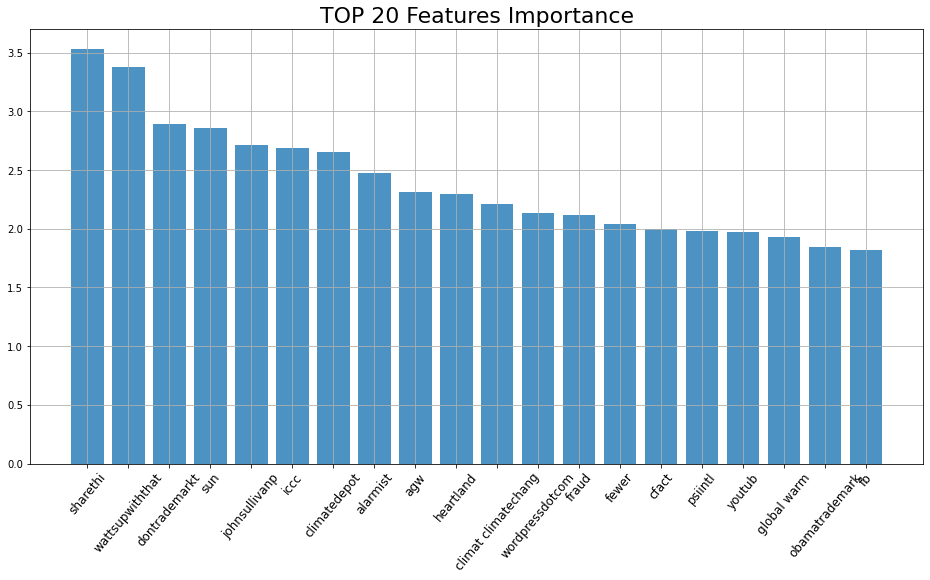

In [13]:
importance = best_model.coef_[0]

indices, importance_sorted = zip(*sorted(enumerate(importance), key=itemgetter(1),reverse=True))

indices,importance_sorted = indices[:20],importance_sorted[:20]

feature_names = BOW_vectorizer.get_feature_names()
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance_sorted))], importance_sorted,align='center',alpha=0.8)
plt.xticks(ticks=range(len(top_features)),labels=top_features,rotation=50,fontsize=12)
plt.title('TOP 20 Features Importance',fontsize=22)
plt.grid()
plt.show()

## CatBoosting Classifier

In [31]:
catboost_accuracy = []
best = 0
for train_index, val_index in tqdm_notebook(kfcv.split(X_train,y_train)):
    XX_train, XX_val = X_train[train_index], X_train[val_index]
    yy_train, yy_val = y_train.values[train_index], y_train.values[val_index]
    clf = cb.CatBoostClassifier(**{"border_count": 200, "depth": 6, "l2_leaf_reg": 10,
                                   "learning_rate": 0.3, "n_estimators": 1000,'verbose':0,'random_state':17})
    clf.fit(XX_train,yy_train)
    pred = clf.predict(XX_val)
    accuracy = accuracy_score(yy_val,pred)
    catboost_accuracy.append(accuracy)
    if accuracy > best:
        best = accuracy
        best_model = clf

c:\users\jason\anaconda3\envs\sl\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


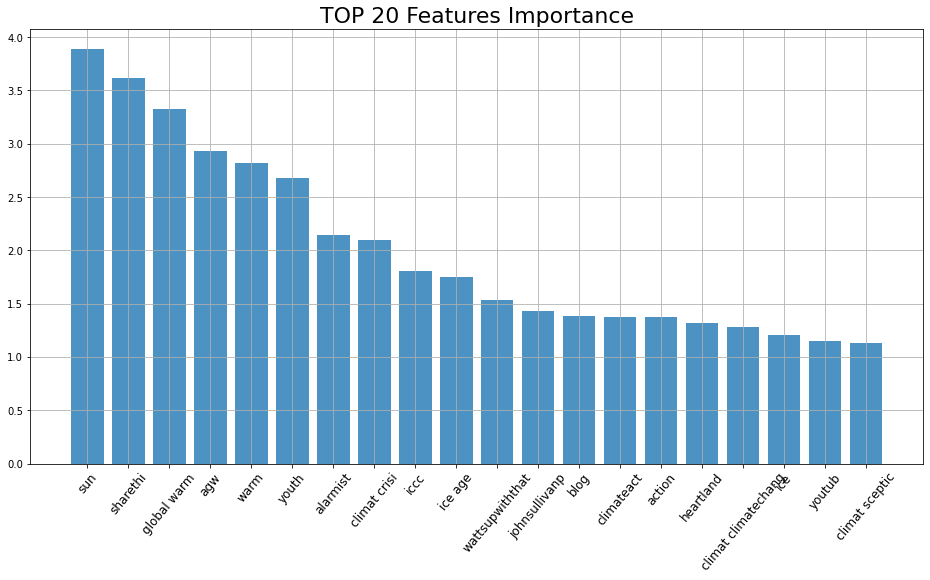

In [32]:
importance = best_model.get_feature_importance()

indices, importance_sorted = zip(*sorted(enumerate(importance), key=itemgetter(1),reverse=True))

indices,importance_sorted = indices[:20],importance_sorted[:20]

feature_names = BOW_vectorizer.get_feature_names()
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance_sorted))], importance_sorted,align='center',alpha=0.8)
plt.xticks(ticks=range(len(top_features)),labels=top_features,rotation=50,fontsize=12)
plt.title('TOP 20 Features Importance',fontsize=22)
plt.grid()

## Support Vector Machine Classifier

In [14]:
svc_accuracy = []
best = 0
for train_index, val_index in tqdm_notebook(kfcv.split(X_train,y_train)):
    XX_train, XX_val = X_train[train_index], X_train[val_index]
    yy_train, yy_val = y_train.values[train_index], y_train.values[val_index]
    clf = SVC(**{'C': 100, 'gamma': 0.001, 'kernel': 'rbf','probability':True,'random_state':17})
    clf.fit(XX_train,yy_train)
    pred = clf.predict(XX_val)
    accuracy = accuracy_score(yy_val,pred)
    svc_accuracy.append(accuracy)
    if accuracy > best:
        best = accuracy
        best_model = clf

c:\users\jason\anaconda3\envs\sl\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


## Gaussian Naive Bayes classifier

In [30]:
nb_accuracy = []
best = 0
for train_index, val_index in tqdm_notebook(kfcv.split(X_train,y_train)):
    XX_train, XX_val = X_train[train_index], X_train[val_index]
    yy_train, yy_val = y_train.values[train_index], y_train.values[val_index]
    clf = GaussianNB(**{'var_smoothing': 0.001})
    clf.fit(XX_train.toarray(),yy_train)
    pred = clf.predict(XX_val.toarray())
    accuracy = accuracy_score(yy_val,pred)
    nb_accuracy.append(accuracy)
    if accuracy > best:
        best = accuracy
        best_model = clf

c:\users\jason\anaconda3\envs\sl\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


## Analysis

In [35]:
def mean_confidence_interval(data):
    '''Function that computes mean and 95% conf. intervals'''
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    standard_error = se/np.sqrt(n)
    h = 1.96*standard_error
    return m, m-h, m+h


random_forest_mean = mean_confidence_interval(rf_accuracy)[0]
logistic_regression_mean = mean_confidence_interval(log_reg_accuracy)[0]
cat_boosting_mean = mean_confidence_interval(catboost_accuracy)[0]
gaussian_naive_bayes_mean = mean_confidence_interval(nb_accuracy)[0]
svc_mean = mean_confidence_interval(svc_accuracy)[0]


random_forest_error = abs(mean_confidence_interval(rf_accuracy)[2]-mean_confidence_interval(rf_accuracy)[0])
logistic_regression_error = abs(mean_confidence_interval(log_reg_accuracy)[2]-mean_confidence_interval(log_reg_accuracy)[0])
cat_boosting_error = abs(mean_confidence_interval(catboost_accuracy)[2]-mean_confidence_interval(catboost_accuracy)[0])
gaussian_naive_bayes_error = abs(mean_confidence_interval(nb_accuracy)[2]-mean_confidence_interval(nb_accuracy)[0])
svc_forest_error = abs(mean_confidence_interval(svc_accuracy)[2]-mean_confidence_interval(svc_accuracy)[0])

In [36]:
mean_list = [random_forest_mean,logistic_regression_mean,cat_boosting_mean,gaussian_naive_bayes_mean,svc_mean]

error_list = [random_forest_error,logistic_regression_error,cat_boosting_error,gaussian_naive_bayes_error,svc_forest_error]

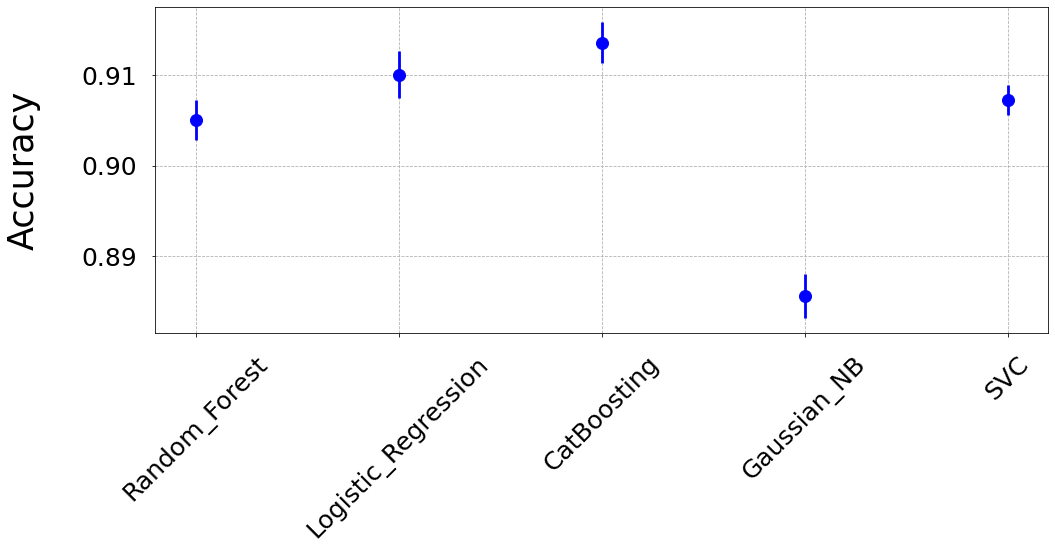

In [43]:
name_list = ['Random_Forest','Logistic_Regression','CatBoosting',
             'Gaussian_NB','SVC']

plt.figure(figsize=(16,6))
a = plt.errorbar(y=mean_list, x=name_list, yerr=error_list, fmt='o', color='blue',
                 capthick=2,linewidth=2.8,markersize=12)
plt.tick_params(axis='both', which='major', labelsize=25, pad=15)       
plt.ylabel('Accuracy',fontsize=35,labelpad=40)
plt.xticks(name_list,rotation=45)
plt.grid(linestyle='--', linewidth=0.8)
plt.show()

## Soft Voting Method

In [47]:
class Majority_vote():
    """
    averaging all models
    """
    def __init__(self,models,threshold=None):
        self.base_models = models
        if threshold:
            self.threshold = threshold
        else:
            self.threshold = 0.5
              
    
    def fit(self,X_train,y_train):
        for model in self.base_models:       
            model.fit(X_train,y_train)

    def predict_score(self,X):
        s = []
        for k,model in enumerate(self.base_models):
            pred = model.predict_proba(X)[:,1]
            s.append(pred)
        s = np.array(s)
        return(np.sum(s,axis=0)/len(self.base_models))
    
    def predict(self,X):
        score = self.predict_score(X)
        pred = np.zeros(X.shape[0])
        pred[score>=self.threshold] = 1
        return pred

![dd](https://miro.medium.com/max/700/1*EekXroXi99N05jcskdPsIg.png)

In [48]:
estimators = [RandomForestClassifier(**{'bootstrap': True,'max_depth': None,'max_features': 'log2',
                                        'min_samples_leaf': 1,'min_samples_split': 10,'n_estimators': 300,
                                        'random_state':17}),
              SVC(**{'C': 100, 'gamma': 0.001, 'kernel': 'rbf','probability':True,'random_state':17}),
              LogisticRegression(**{'C':1,'max_iter':1000, 'multi_class':"ovr", 'solver':"saga",'random_state':17}),
              cb.CatBoostClassifier(**{"border_count": 200, "depth": 6, "l2_leaf_reg": 10,
                                       "learning_rate": 0.3, "n_estimators": 1000,'verbose':0,'random_state':17})]

In [49]:
majority_accuracy = []
for train_index, val_index in tqdm_notebook(kfcv.split(X_train,y_train)):
    XX_train, XX_val = X_train[train_index], X_train[val_index]
    yy_train, yy_val = y_train.values[train_index], y_train.values[val_index]
    clf = Majority_vote(estimators)
    clf.fit(XX_train,yy_train)
    pred = clf.predict(XX_val)
    accuracy = accuracy_score(yy_val,pred)
    majority_accuracy.append(accuracy)

c:\users\jason\anaconda3\envs\sl\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [50]:
majority_mean = mean_confidence_interval(majority_accuracy)[0]

majority_error = abs(mean_confidence_interval(majority_accuracy)[2]-mean_confidence_interval(majority_accuracy)[0])

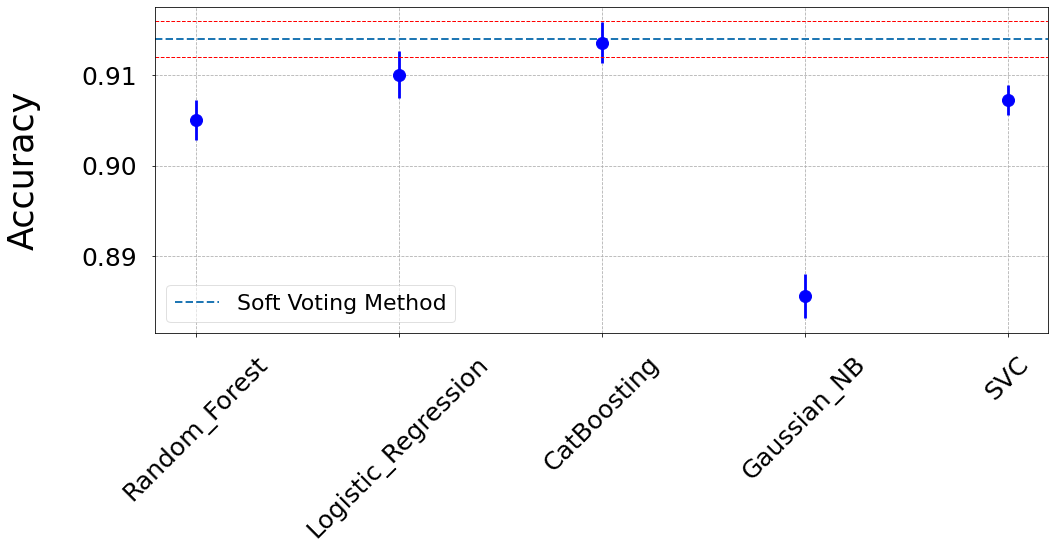

In [51]:
name_list = ['Random_Forest','Logistic_Regression','CatBoosting',
             'Gaussian_NB','SVC']

plt.figure(figsize=(16,6))
a = plt.errorbar(y=mean_list, x=name_list, yerr=error_list, fmt='o', color='blue',
                 capthick=2,linewidth=2.8,markersize=12)
b = plt.axhline(majority_mean, ls='--',lw=2,) 
plt.axhline(majority_mean+majority_error, ls='--',lw=1,color='r') 
plt.axhline(majority_mean-majority_error, ls='--',lw=1,color='r') 
plt.tick_params(axis='both', which='major', labelsize=25, pad=15)       
plt.ylabel('Accuracy',fontsize=35,labelpad=40)
plt.xticks(name_list,rotation=45)
plt.legend([b],['Soft Voting Method'],
           loc='best',prop={'size': 22},framealpha=0.6)
plt.grid(linestyle='--', linewidth=0.8)
plt.show()

In [52]:
def plot_figure(X,y,clf):
    '''Plots Precision-Recall & ROC curves'''

    y_score = clf.predict_score(X)
    average_precision = average_precision_score(y, y_score)

    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))




    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)

    #plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.grid()
    
    plt.show()

#######################

Accuracy: 0.9217
Precision: 0.928
Recall: 0.9411
F1_score: 0.9345
F2_score: 0.9384
F5_score: 0.9406
AUC_score: 0.9741
1-Brier_score: 0.9396

#######################

Average precision-recall score: 0.98


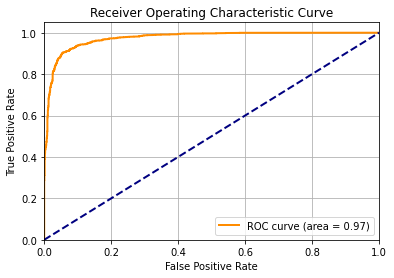

In [54]:
clf = Majority_vote(estimators)
clf.fit(X_train,y_train)

pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
precision = precision_score(y_test,pred)
recall = recall_score(y_test,pred)
f1 = f1_score(y_test,pred)
f2 = fbeta_score(y_test,pred,beta=2)
f5 = fbeta_score(y_test,pred,beta=5)
y_score = clf.predict_score(X_test)
auc_score = roc_auc_score(y_test,y_score)
brier_score = brier_score_loss(y_test, y_score)


print('#######################\n')
print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('F1_score: {}'.format(round(f1,4)))
print('F2_score: {}'.format(round(f2,4)))
print('F5_score: {}'.format(round(f5,4)))
print('AUC_score: {}'.format(round(auc_score,4)))
print('1-Brier_score: {}'.format(round(1-brier_score,4)))
print()
print('#######################\n')


plot_figure(X_test,y_test,clf)